# Project :- Ecommerce Sales

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector as msc

In [3]:
csv_files = [
    ('customers.csv','customers'),
    ('geolocation.csv','geolocation'),
    ('order_items.csv','orders_items'),
    ('orders.csv','orders'),
    ('payments.csv','payments'),
    ('products.csv','products'),
    ('sellers.csv', 'sellers')
]

In [4]:
from sqlalchemy import create_engine

In [5]:
# Connect to the mysql database

conn = msc.connect(host = '127.0.0.1',
                   username = 'root',
                   password =  'Vinay@2002',
                  database = 'Ecommerce')


cur = conn.cursor()
                


In [6]:

# Folder containing the CSV files
folder_path = "C:/Users/Vinay Raykar/OneDrive/Documents/My Courses/Youtube Projects/Project 3-  E-Commerce Sales/Ecommerce Dataset"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cur.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cur.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


In [7]:
## Creation of database
# query = 'CREATE DATABASE Ecommerce'

# cur.execute(query)

# conn.commit()
# conn.close()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


# Basic Queries

**List all unique cities where customers are located.**

In [9]:
conn = msc.connect(host = '127.0.0.1',
                   username = 'root',
                   password =  'Vinay@2002',
                  database = 'Ecommerce')


cur = conn.cursor()

query = "Select DISTINCT customer_city from customers"
cur.execute(query)

data = cur.fetchall()

unique_city = pd.DataFrame(data, columns = ["Customer's City"])


In [10]:
print(f"There are {unique_city.value_counts().sum()} unique customer's cities")
unique_city

There are 4119 unique customer's cities


,Customer's City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


**2. Count the number of orders placed in 2017.**

In [11]:
query = """Select count(order_id) from orders WHERE year(order_approved_at) = 2017"""
cur.execute(query)

data = cur.fetchall()
print("Total order were placed in 2017:-", data[0][0], "Units")

Total order were placed in 2017:- 89946 Units


**3. Find the total sales per category.**

Category    0
Sales       0
dtype: int64


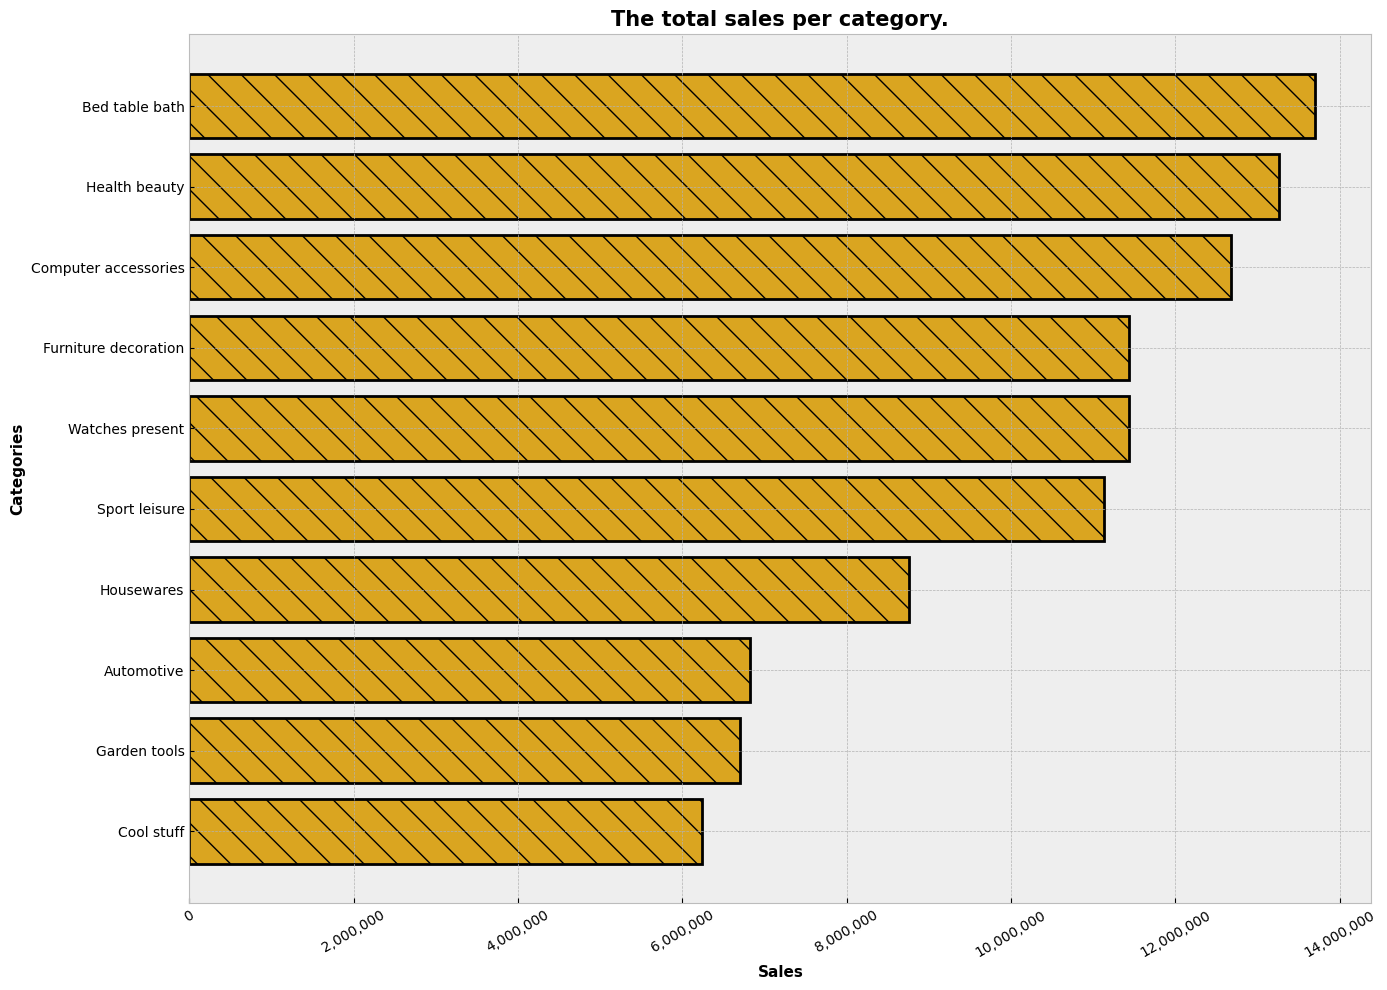

In [12]:
query = """SELECT CONCAT(UPPER(LEFT(products.product_category,1)), LOWER(SUBSTRING(products.product_category,2))) as category, 
round(sum(payments.payment_value),2) as price
FROM products JOIN orders_items
ON products.product_id = orders_items.product_id
JOIN payments
ON payments.order_id = orders_items.order_id
GROUP BY category
ORDER BY price DESC
"""
cur.execute(query)

data = cur.fetchall()
sale_category = pd.DataFrame(data, columns = ["Category", "Sales"])
sale_category

#Drop null values from column category
clean_df = sale_category.dropna(subset = ['Category'])
print(clean_df.isnull().sum())

# Top 10 Category
clean_df = clean_df.head(10)

# Visualization
fig = plt.figure(figsize = (14,10))

plt.style.use('bmh')
# fig.patch.set_facecolor('white')

plt.barh(y = clean_df["Category"], width = clean_df["Sales"], edgecolor= 'black' , linewidth = 2, color = 'goldenrod' , hatch = '\\')

# converts into full number
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.gca().invert_yaxis()

plt.title("The total sales per category.", fontweight = 'bold', fontsize = 15)
plt.xticks(rotation =30)
plt.xlabel("Sales", fontweight = 'bold', fontsize = 11 )
plt.ylabel("Categories", fontweight = 'bold', fontsize = 11)


plt.tight_layout()
plt.show()

In [13]:
print("The total sales per category.:\n")
clean_df

The total sales per category.:



,Category,Sales
0,Bed table bath,13700429.37
1,Health beauty,13258984.96
2,Computer accessories,12682643.57
3,Furniture decoration,11441411.13
4,Watches present,11433733.43
5,Sport leisure,11137020.47
6,Housewares,8758065.04
7,Automotive,6818354.65
8,Garden tools,6706246.01
9,Cool stuff,6237584.00


**4. Calculate the percentage of orders that were paid in installments.**

In [14]:
query1 = """SELECT (sum(CASE WHEN payment_installments >= 1 THEN 1
ELSE 0 END))/count(*)*100 FROM payments"""

cur.execute(query1)

data = cur.fetchall()

print(f'{data[0][0]} % of orders that were paid by in installments.')

99.9981 % of orders that were paid by in installments.


**5. Count the number of customers from each state.**

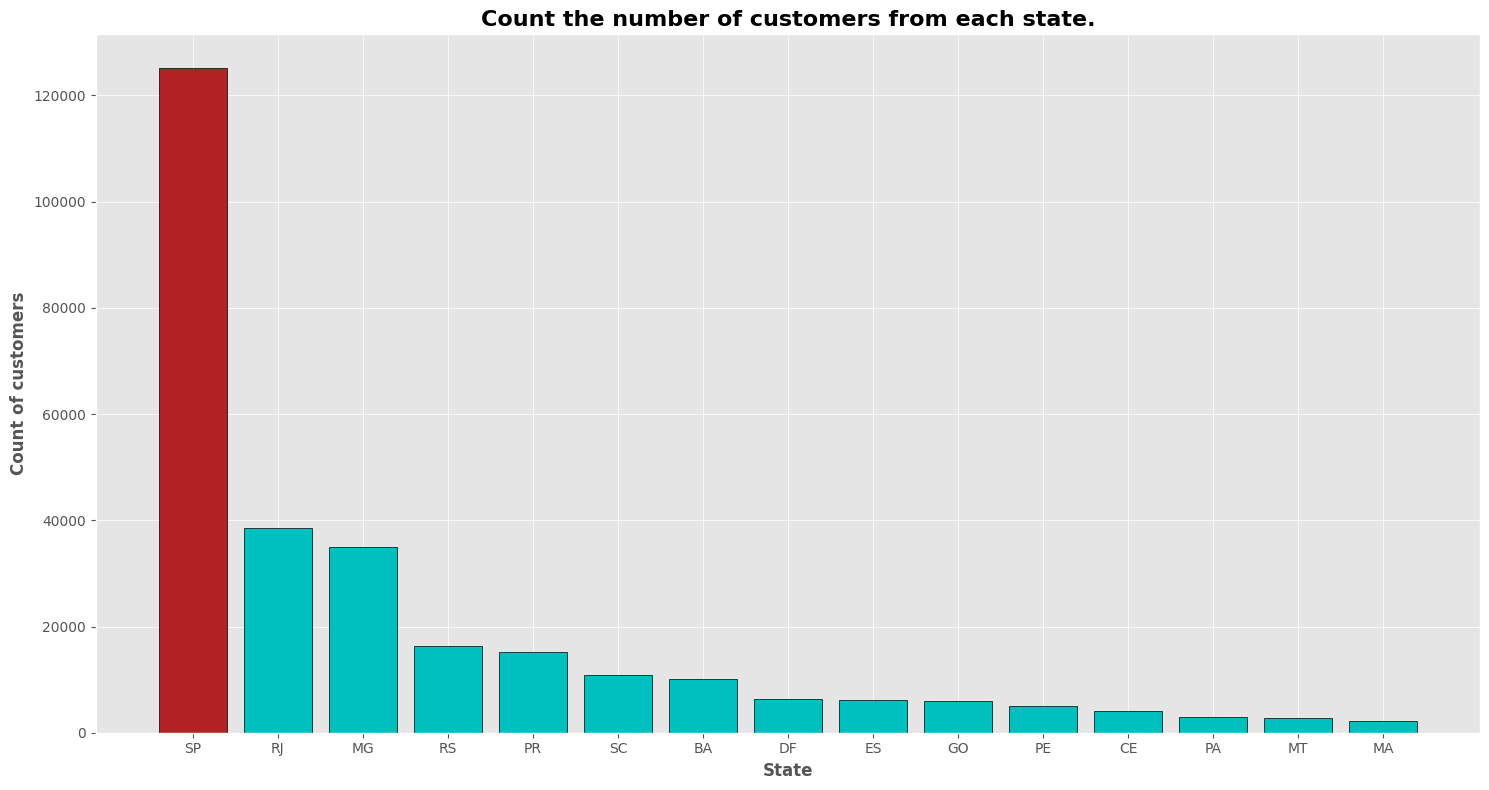

The state SP has 80k+ count of the customers number.


In [40]:
query = """SELECT customer_state, count(customer_unique_id) FROM customers
GROUP BY customer_state
"""

cur.execute(query)

data = cur.fetchall()

customer_count = pd.DataFrame(data, columns = ["State", "Count of customers"])

#Plot the bar graph

plt.figure(figsize = (15,8))
plt.style.use('ggplot')

customer_count = customer_count.sort_values(by ='Count of customers', ascending = False).head(15)

#color indicator
colors = ['firebrick'] + ['c'] * 15

count = plt.bar(customer_count['State'], customer_count['Count of customers'], edgecolor = 'black', color = colors)
plt.title("Count the number of customers from each state.", fontweight = 'bold' , fontsize = 16)
plt.xlabel("State", fontweight = 'bold' , fontsize = 12)
plt.ylabel('Count of customers', fontweight = 'bold' , fontsize = 12)
plt.xticks(rotation = 0)



plt.tight_layout()
plt.show()

print('The state SP has 80k+ count of the customers number.')

In [16]:
customer_count

,State,Count of customers
0,SP,125238
4,RJ,38556
2,MG,34905
5,RS,16398
3,PR,15135
1,SC,10911
9,BA,10140
13,DF,6420
8,ES,6099
7,GO,6060


**6. Top Customers by Revenue**

In [129]:
query = """Select customer_unique_id as Customers,
ROUND(SUM(payments.payment_value),2) as Revenue

FROM payments 
JOIN orders
ON payments.order_id = orders.order_id
JOIN customers
ON customers.customer_id = orders.customer_id

GROUP BY Customers
ORDER BY Revenue DESc;"""


cur.execute(query)

data = cur.fetchall()
cust_reve= pd.DataFrame(data, columns = ["Customer", "Revenue"])
cust_reve = cust_reve.head(10)


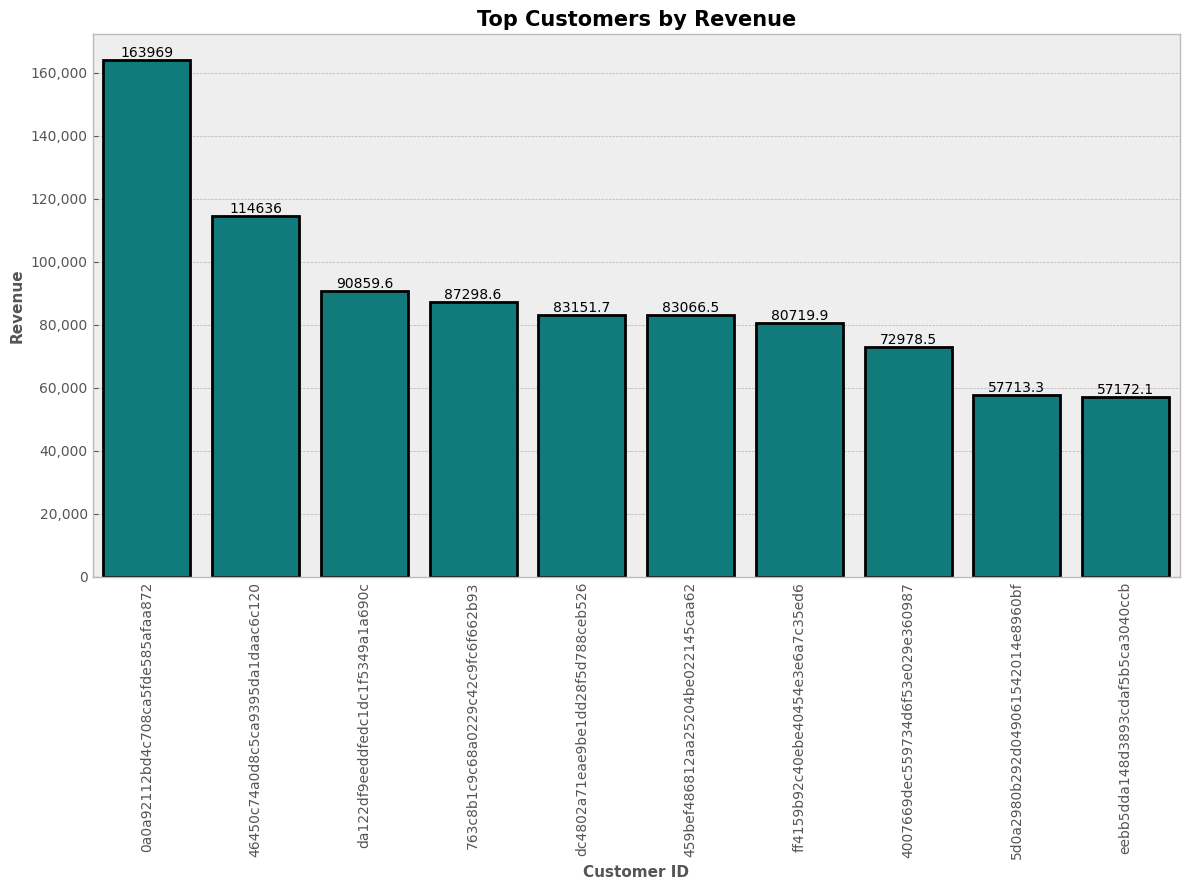

In [174]:
#Visualize
plt.figure(figsize = (12,9))

plt.style.use('bmh')
count = sns.barplot(data = cust_reve, x = cust_reve["Customer"], y = cust_reve["Revenue"], edgecolor= 'black' , linewidth = 2, color = 'darkcyan')

# View the values of y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Top Customers by Revenue", fontweight = 'bold', fontsize = 15, color = 'k')
plt.xticks(rotation = 90)
plt.xlabel("Customer ID", fontweight = 'bold', fontsize = 11 )
plt.ylabel("Revenue", fontweight = 'bold', fontsize = 11)


#Data Labels
for bar in count.containers:
    count.bar_label(bar)

plt.tight_layout()
plt.show()

**7. Monthly Order Volumes**

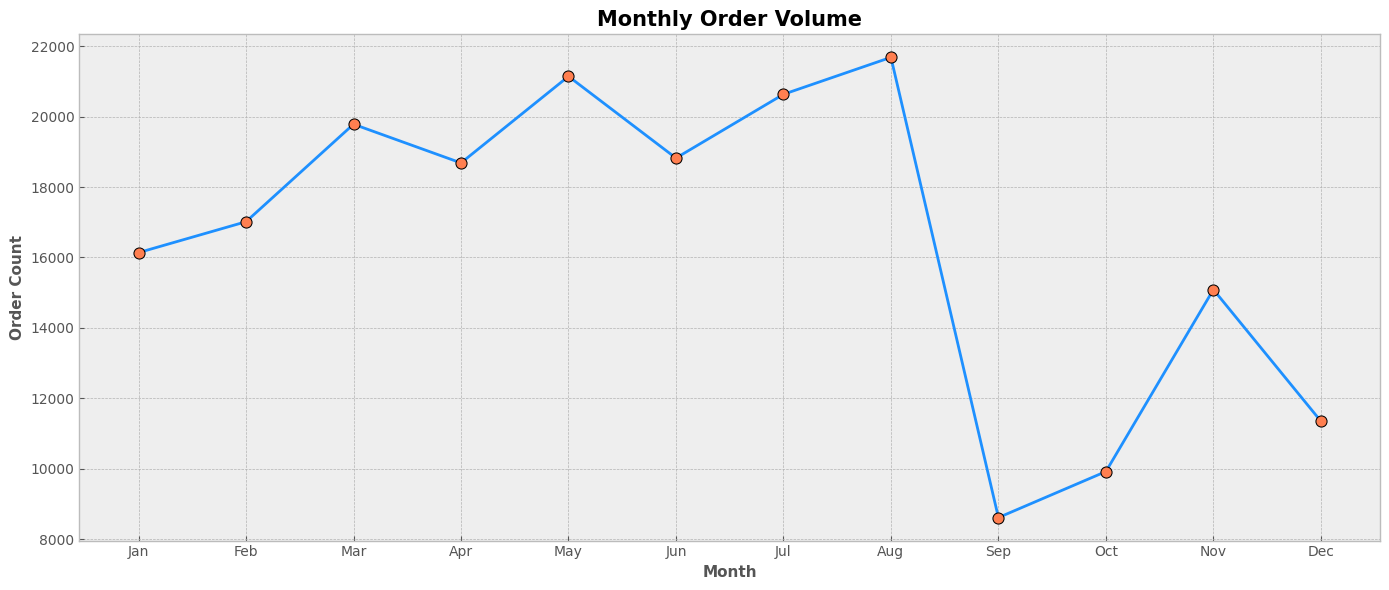

In [157]:
query = """SELECT MONTH(order_purchase_timestamp) as Monthly,
COUNT(order_id) as Order_Count
FROM orders
GROUP BY Monthly
ORDER BY Monthly ASC;"""


cur.execute(query)

data = cur.fetchall()
Monthly_vol= pd.DataFrame(data, columns = ["Month", "Order_Count"])


# Visualize 
plt.figure(figsize = (14,6))
plt.style.use('bmh')

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Monthly_vol['Month_name'] = Monthly_vol['Month'].apply(lambda x : month_names[x-1])

# Seaborn Line plot
sns.lineplot(data = Monthly_vol, x = "Month_name", y = "Order_Count" , 
             marker = 'o', mfc = 'coral', 
             mec = 'k', ms = 8, 
             linewidth = 2, color = 'dodgerblue')


plt.title("Monthly Order Volume", fontweight='bold', fontsize=15)
plt.xlabel("Month", fontweight='bold', fontsize=11)
plt.ylabel("Order Count", fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Intermediate Queries

**1. Calculate the number of orders per month in 2018.**

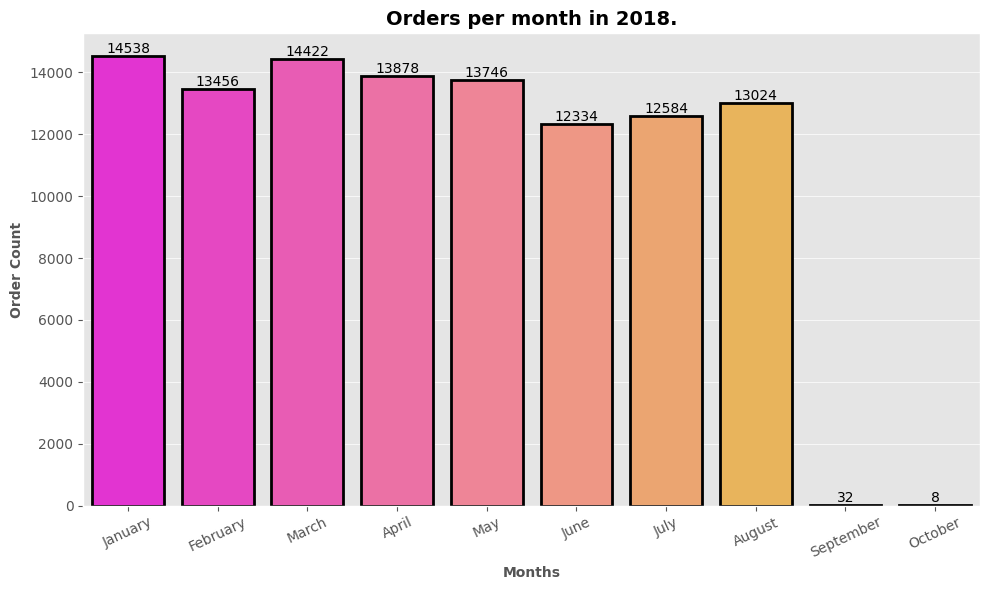

In [17]:
query = """SELECT monthname(order_purchase_timestamp) as Month, count(order_id) as Order_count FROM orders
WHERE year(order_purchase_timestamp) = 2018
GROUP BY  Month
"""

cur.execute(query)

data = cur.fetchall()
orders_2018 = pd.DataFrame(data, columns =["Months", "Order_Count"])

plt.figure(figsize = (10,6))
orders = ['January','February','March','April','May','June','July','August','September','October']

count = sns.barplot(x = orders_2018['Months'],y = orders_2018['Order_Count'], data = orders_2018, order = orders, edgecolor = 'black', palette = 'spring', linewidth = 2)
 
plt.title("Orders per month in 2018." ,  fontweight = 'bold' , fontsize = 14)
plt.xlabel("Months", fontweight = 'bold' , fontsize = 10)
plt.ylabel('Order Count', fontweight = 'bold' , fontsize = 10)
           
plt.xticks(rotation = 25)


for bar in count.containers:
    count.bar_label(bar)

plt.tight_layout()
plt.show()

In [18]:
orders_2018

,Months,Order_Count
0,July,12584
1,August,13024
2,February,13456
3,June,12334
4,March,14422
5,January,14538
6,May,13746
7,April,13878
8,September,32
9,October,8


**2. Find the average number of products per order, grouped by customer city.**

In [19]:
query = """with count_per_order as
(SELECT orders.order_id, orders.customer_id, count(orders_items.order_id) as oc
FROM orders JOIN orders_items
ON orders.order_id = orders_items.order_id
GROUP BY  orders.order_id, orders.customer_id)

SELECT customers.customer_city, round(avg(count_per_order.oc), 2) as Avg_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY Avg_orders Desc
"""
 
cur.execute(query)

data = cur.fetchall()

avg_order = pd.DataFrame(data, columns = ["City", "Avg_orders"])

# only top 10
avg_order = avg_order.head(10)

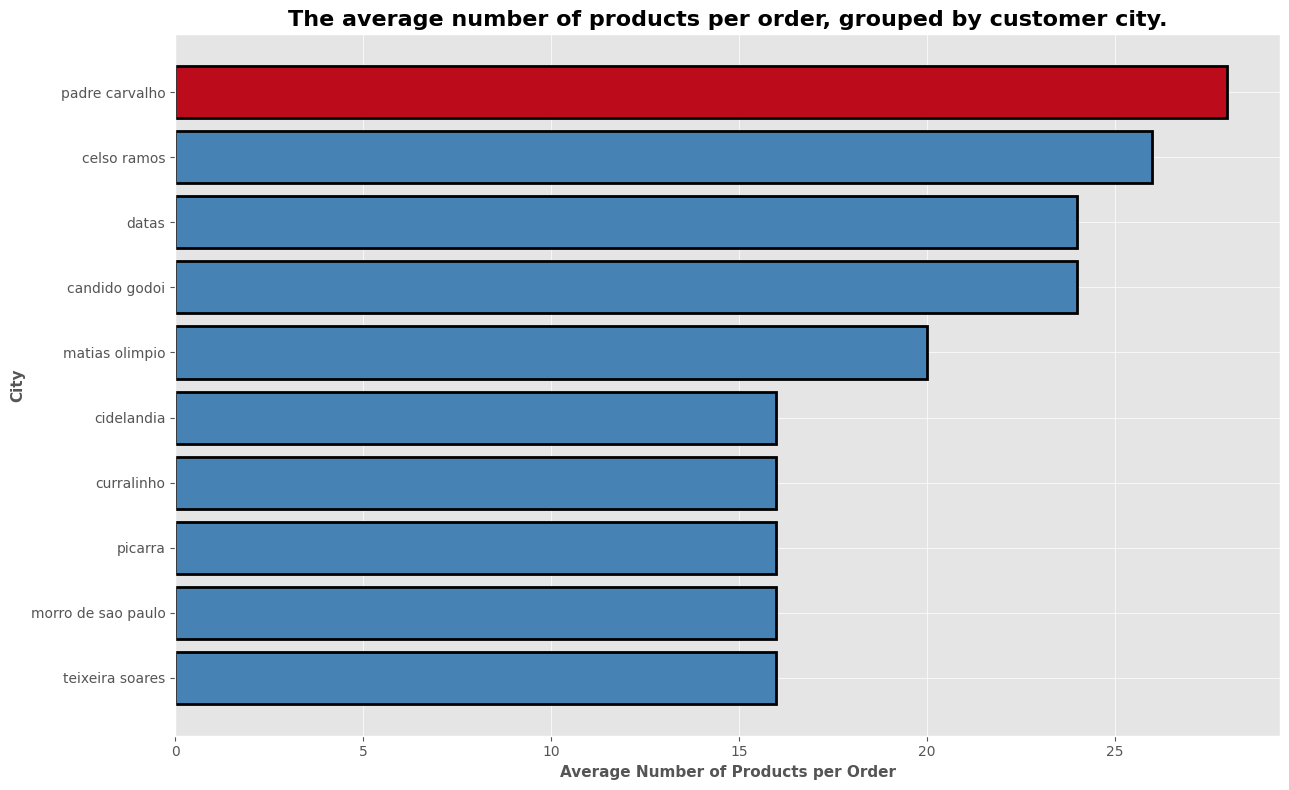

In [20]:
colors = ['#bc0c1c'] + ['steelblue'] * 9

plt.figure(figsize = (13,8))


plt.barh(y = avg_order['City'], width = avg_order['Avg_orders'],color = colors, edgecolor = 'k', linewidth = 2 )

plt.gca().invert_yaxis()

plt.title("The average number of products per order, grouped by customer city." ,  fontweight = 'bold' , fontsize = 16)
plt.xlabel('Average Number of Products per Order', fontweight = 'bold' , fontsize = 11)
plt.ylabel('City', fontweight = 'bold' , fontsize = 11)


plt.tight_layout()
plt.show()

In [21]:
avg_order.head(10)

,City,Avg_orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


**3. Calculate the percentage of total revenue contributed by each product category.**

In [22]:
query = """SELECT CONCAT(UPPER(LEFT(products.product_category,1)), LOWER(SUBSTRING(products.product_category, 2))),
round(sum((payments.payment_value)/(SELECT sum(payment_value) FROM payments))* 100,2) as Percentage
FROM products JOIN orders_items
ON products.product_id = orders_items.product_id
JOIN payments
ON payments.order_id = orders_items.order_id
GROUP BY products.product_category
ORDER BY Percentage DESC
"""

cur.execute(query)

data = cur.fetchall()

revenue_pct = pd.DataFrame(data, columns = ["Product_category","Percentage"])
revenue_pct ['Percentage'] = revenue_pct ['Percentage'].astype(str) + ' %'


In [23]:
revenue_pct .head(10)

,Product_category,Percentage
0,Bed table bath,42.79 %
1,Health beauty,41.41 %
2,Computer accessories,39.61 %
3,Furniture decoration,35.73 %
4,Watches present,35.71 %
5,Sport leisure,34.78 %
6,Housewares,27.35 %
7,Automotive,21.3 %
8,Garden tools,20.95 %
9,Cool stuff,19.48 %


**4. Identify the correlation between product price and the number of times a product has been purchased.**

In [24]:
query = """SELECT products.product_category AS Category,
count(orders_items.price) AS Count,
round(AVG(orders_items.price),2) AS Average_price
FROM products JOIN orders_items
ON products.product_id = orders_items.product_id
GROUP BY Category
ORDER BY Average_price DESC;
"""

cur.execute(query)

data = cur.fetchall()
corr_prd_price = pd.DataFrame(data, columns = ["Product_category","Count", "Average_price"])

#To find out Correlation
corr = corr_prd_price.corr(numeric_only = True)

In [25]:
corr

,Count,Average_price
Count,1.000000,-0.106315
Average_price,-0.106315,1.000000


In [26]:
corr_prd_price.head(10)

,Product_category,Count,Average_price
0,PCs,812,1098.34
1,HOUSE PASTALS OVEN AND CAFE,304,624.29
2,ELECTRICES 2,952,476.12
3,Agro Industria e Comercio,848,342.12
4,musical instruments,2720,281.62
5,electrostile,2716,280.78
6,Kitchen portable and food coach,60,264.57
7,fixed telephony,1056,225.69
8,CONSTRUCTION SECURITY TOOLS,776,208.99
9,Watches present,23964,201.14


 **5. Calculate the total revenue generated by each seller, and rank them by revenue.**

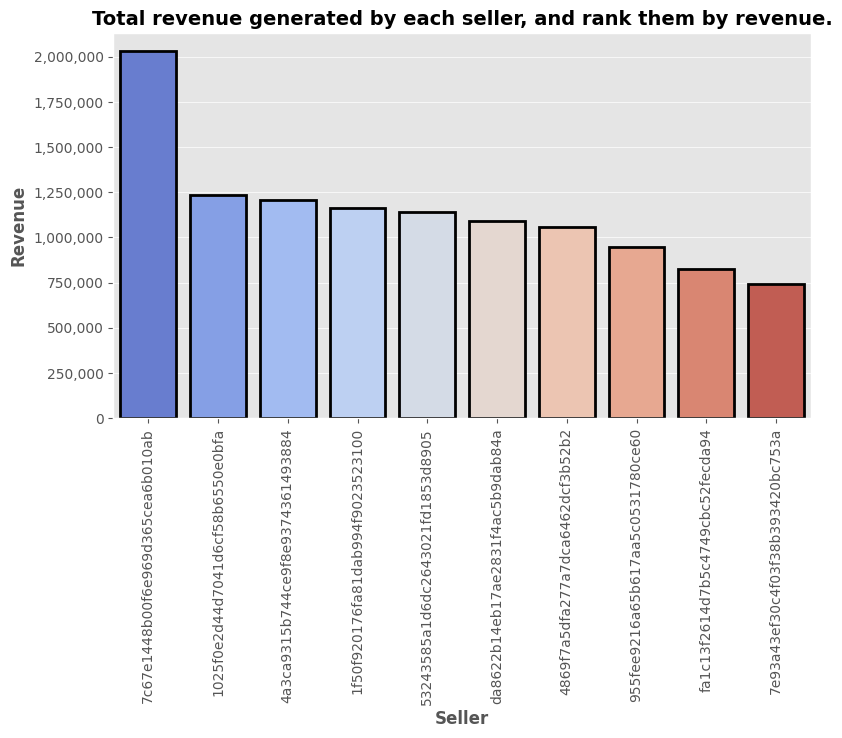

Seller Id :- 7c67e1448b00f6e969d365cea6b010ab is in the First Rank for generating the maximum revenue 


In [27]:
# Using Window function.
query = """SELECT *, dense_rank() over(ORDER BY Revenue DESC) as rank_seller FROM
(SELECT DISTINCT orders_items.seller_id, 
round(sum(payments.payment_value),2) Revenue
FROM orders_items JOIN payments
ON payments.order_id = orders_items.order_id
GROUP BY orders_items.seller_id) as Seller_group
LIMIT 10
"""

cur.execute(query)

data = cur.fetchall()

seller_rank = pd.DataFrame(data, columns = ["Seller_id","Revenue", "Rank"])

# BAR Ploting
plt.figure(figsize = (9,5))
sns.barplot(data = seller_rank, x = seller_rank['Seller_id'], y = seller_rank['Revenue'], edgecolor = 'black', linewidth = 2, palette = 'coolwarm')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Total revenue generated by each seller, and rank them by revenue." ,  fontweight = 'bold' , fontsize = 14)
plt.xlabel("Seller", fontweight = 'bold')
plt.ylabel("Revenue", fontweight = 'bold')
plt.xticks(rotation = 90)


plt.show()

print(f'Seller Id :- {seller_rank['Seller_id'][0]} is in the First Rank for generating the maximum revenue ')

In [198]:
seller_rank

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1088877.28,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1056664.48,7
7,955fee9216a65b617aa5c0531780ce60,945289.20,8
8,fa1c13f2614d7b5c4749cbc52fecda94,826052.92,9
9,7e93a43ef30c4f03f38b393420bc753a,740536.84,10


# Advanced Queries.

**1. Calculate the moving average of order values for each customer over their order history.**

In [29]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (Partition By customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 Preceding AND current row) as Moving_avg
FROM
(SELECT orders.customer_id, payments.payment_value as payment, orders.order_purchase_timestamp
FROM orders JOIN payments 
ON payments.order_id = orders.order_id) as order_pay 
"""

cur.execute(query)

data = cur.fetchall()
moving_avg = pd.DataFrame(data, columns = ["Customer ID", "Order purchase timestamp" ,"Price" ,"Moving Average"])

print("The moving average of order values for each customer over their order history.\n")
moving_avg

The moving average of order values for each customer over their order history.



,Customer ID,Order purchase timestamp,Price,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


**2. Calculate the cumulative sales per month for each year.**

In [30]:
query = """SELECT years, months, payment , sum(payment)
over (ORDER BY years, months) cumulative_sales
FROM 
(SELECT month(orders.order_purchase_timestamp) as months , year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
FROM orders JOIN payments
ON orders.order_id = payments.payment_value
GROUP BY months, years
ORDER BY months, years) as order_pay; 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Months" ,"Price", "SUM Payments"])
df


,Years,Months,Price,SUM Payments
0,2016,9,0.0,0.0
1,2016,10,360072.0,360072.0
2,2016,12,0.0,360072.0
3,2017,1,607128.0,967200.0
4,2017,2,1416372.0,2383572.0
5,2017,3,2304184.0,4687756.0
6,2017,4,2056356.0,6744112.0
7,2017,5,3180624.0,9924736.0
8,2017,6,2765740.0,12690476.0
9,2017,7,3395988.0,16086464.0


**3. Calculate the year-over-year growth rate of total sales.**

In [31]:
query = """with a as(SELECT year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years)


SELECT years, 
round((payment - lag(payment, 1) over(ORDER BY years))/
lag(payment, 1) over(ORDER BY years)) * 100 from a"""




cur.execute(query)

data = cur.fetchall()

yoy = pd.DataFrame(data, columns = ["Years", "YOY Growth"])
yoy


,Years,YOY Growth
0,2016,NaN
1,2017,12100.0
2,2018,0.0


**4. Identify the top 3 customers who spent the most money in each year.**

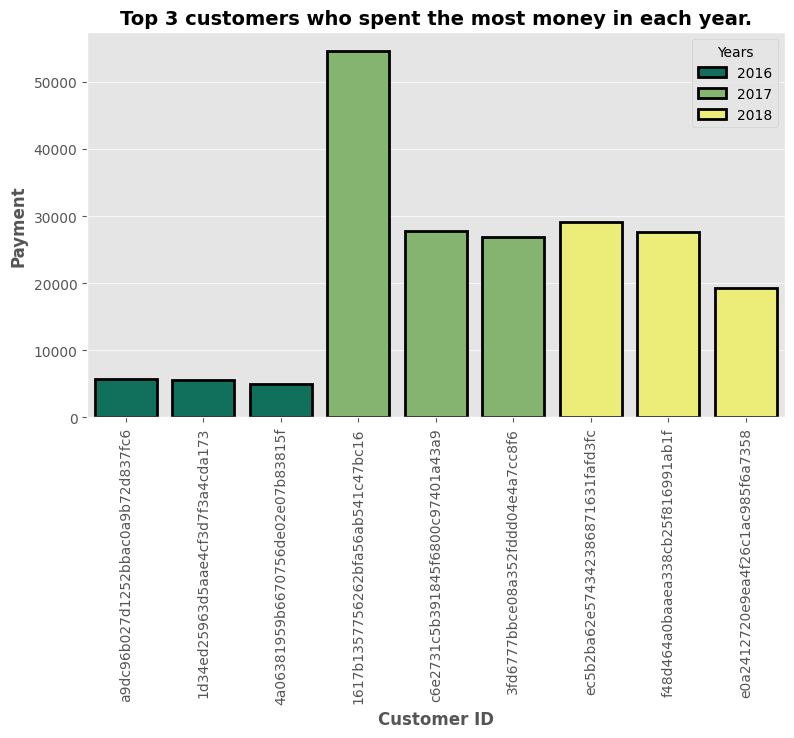

In [32]:
query = """SELECT years, customer_id, payment, d_rank
FROM
(SELECT year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) 
ORDER BY sum(payments.payment_value) desc) d_rank
FROM orders JOIN payments
ON payments.order_id = orders.order_id
GROUP BY years,
orders.customer_id) as a
WHERE d_rank <= 3"""


cur.execute(query)

data = cur.fetchall()
top_3 = pd.DataFrame(data, columns = ["Years", "Customer ID", "Payment", "Rank"])
top_3

plt.figure(figsize = (9,5))
sns.barplot(data = top_3, x = 'Customer ID', y = top_3['Payment'],hue = 'Years', edgecolor = 'black', linewidth = 2, palette = 'summer')

plt.title("Top 3 customers who spent the most money in each year." ,  fontweight = 'bold' , fontsize = 14)
plt.xlabel("Customer ID", fontweight = 'bold')
plt.ylabel("Payment", fontweight = 'bold')
plt.xticks(rotation = 90)

plt.show()

# DashBoard

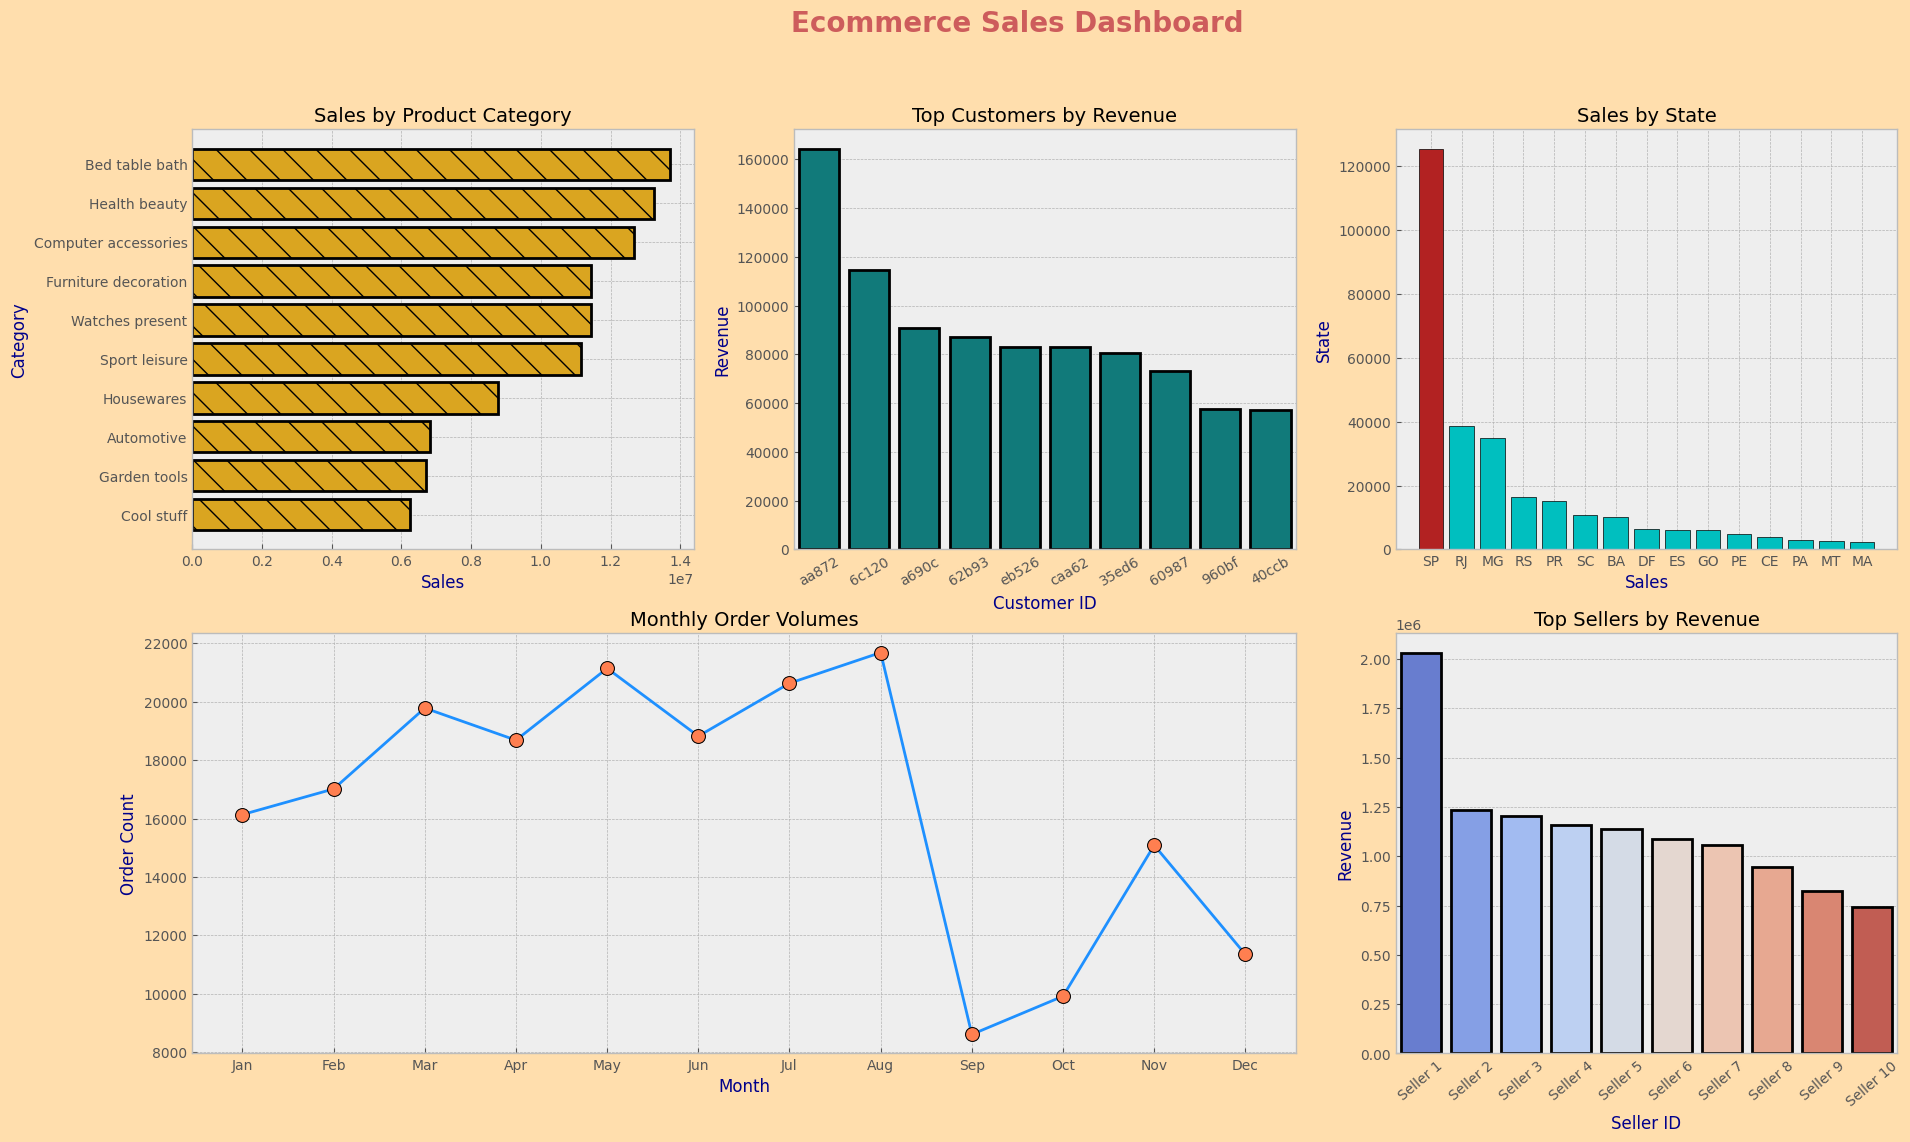

In [196]:

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(22, 12))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
fig.suptitle("Ecommerce Sales Dashboard",color = 'indianred', fontsize=20, fontweight="bold")

fig.patch.set_facecolor('navajowhite')

# 1. Sales by Product Category
ax0 = plt.subplot(gs[0, 0])
plt.barh(y = clean_df["Category"], width = clean_df["Sales"], edgecolor= 'black' , linewidth = 2, color = 'goldenrod' , hatch = '\\')
ax0.set_title('Sales by Product Category', fontsize=14)
ax0.set_xlabel('Sales', color = 'darkblue')
ax0.set_ylabel('Category', color = 'darkblue')
plt.gca().invert_yaxis()

# 2. Top Customers by Revenue
customers = ['aa872','6c120','a690c','62b93','eb526','caa62','35ed6','60987','960bf','40ccb']
ax1 = plt.subplot(gs[0, 1])
sns.barplot(data = cust_reve, x = cust_reve["Customer"], y = cust_reve["Revenue"], edgecolor= 'black' , linewidth = 2, color = 'darkcyan')
ax1.set_title('Top Customers by Revenue', fontsize=14)
ax1.set_xlabel('Customer ID', color = 'darkblue')
ax1.set_ylabel('Revenue', color = 'darkblue')
plt.xticks(rotation = 30,ticks = range(0,10), labels = customers)

# 3. Sales by State
ax2 = plt.subplot(gs[0, 2])
plt.bar(customer_count['State'], customer_count['Count of customers'], edgecolor = 'black', color = colors)
ax2.set_title('Sales by State', fontsize=14)
ax2.set_xlabel('Sales', color = 'darkblue')
ax2.set_ylabel('State', color = 'darkblue')

# 4. Monthly Order Volumes
ax3 = plt.subplot(gs[1, 0:2])
sns.lineplot(data = Monthly_vol, x = "Month_name", y = "Order_Count" , 
             marker = 'o', mfc = 'coral', 
             mec = 'k', ms = 10, 
             linewidth = 2, color = 'dodgerblue' )


ax3.set_title('Monthly Order Volumes', fontsize=14)
ax3.set_xlabel('Month', color = 'darkblue')
ax3.set_ylabel('Order Count', color = 'darkblue')


# 5. Top Sellers by Revenue
ax4 = plt.subplot(gs[1, 2])
sellers = ['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6','Seller 7','Seller 8','Seller 9','Seller 10']

sns.barplot(data = seller_rank, x = 'Seller_id', y = 'Revenue', edgecolor = 'black', linewidth = 2, palette = 'coolwarm')
ax4.set_title('Top Sellers by Revenue', color = 'k', fontsize=14)
ax4.set_xlabel('Seller ID', color = 'darkblue')
ax4.set_ylabel('Revenue', color = 'darkblue')
plt.xticks(rotation = 40, ticks = range(0,10), labels = sellers)

plt.tight_layout(rect=[0, 0.03, 0.1, 0.93])
plt.show()

# plt.savefig("Ecommerce Sales Dashboard.png", dpi = 300, bbox_inches = 'tight')